<div align="center">
    <img src="img/LOGO.png" alt="Logo">
</div>



***

## 1. Introdução:
Neste projeto, vou criar um algoritmo para corrigir provas de múltipla escolha. Dada uma imagem do gabarito, o algoritmo deve transcrever os dígitos escritos à mão do "ID" e identificar qual alternativa foi marcada em cada questão. Para isso, criei um modelo de prova de múltipla escolha fictício apenas para fins de teste. Você pode vê-lo abaixo.

 **Bibliotecas utilizadas:**
  - **Scipy - find_peaks:** Dada uma lista, ele identificará todos os picos.
  - **Matplotlib:** Biblioteca base para gerar visualizações. (gráficos, mostrar imagens)
  - **Numpy:** Útil para fazer operações em matrizes.
  - **OpenCV:** Utilizada para ler e processar imagens.
  - **Keras:** Usaremos para criar nossa rede neural no final do projeto.
  - **Keras.datasets:** Utilizaremos o dataset MNIST para treinar nossa rede neural.

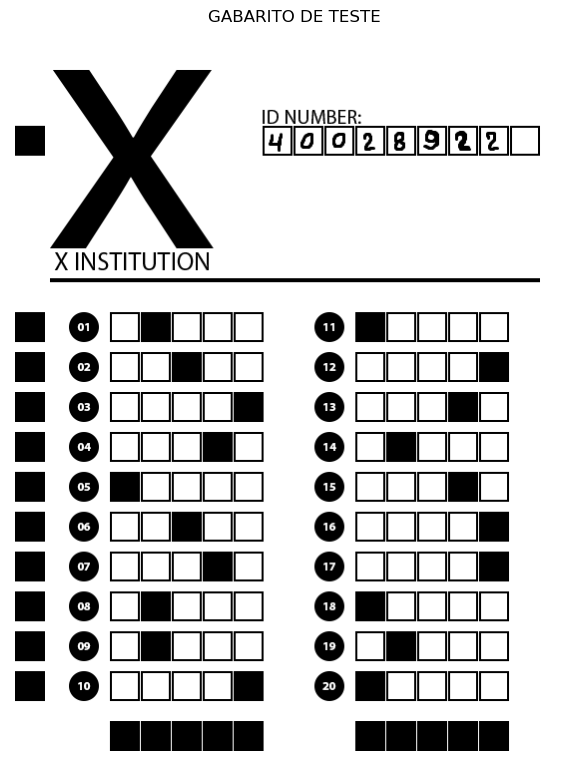

In [20]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np
import cv2 # openCV

mc_test = cv2.imread("img/final.png", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(7, 8))
plt.imshow(mc_test, cmap="gray")
plt.title("GABARITO DE TESTE")
plt.tight_layout()
plt.axis("off")
plt.show()

## 2. Pré-processamento de imagem:
Uma etapa crucial na visão computacional é pré-processar nossos dados. Pode ser qualquer coisa, como redimensionar, orientar ou corrigir cores em uma imagem. Por exemplo, se você deseja detectar objetos em uma imagem, pode usar um Filtro de  Sobel, ele enfatiza as bordas da imagem, tornando mais fácil para nosso modelo detectar cada objeto por sua forma. Nesta aplicação, usaremos técnicas de processamento muito mais básicas, explicarei todas elas abaixo:

 - **"Binarizar" imagem:** Aqui lidaremos com imagens em tons de cinza, ou seja, nossa imagem é uma matriz composta por valores que variam de 0 a 255. Para tornar nossa analise mais precisa, podemos binarizar nossa imagem, ou seja, transformar em 0 ou 1 (preto ou branco). Sendo "X" cada pixel em nossa imagem, aplicaremos a seguinte operação:
 
</br>
\begin{cases}
x=1, & \text{se } x \geq 127 \\
x=0, & \text{se } x < 127 \\
\end{cases}
</br>

 - **Erosão:** Resumidamente, essa técnica "encolhe" objetos na imagem. É muito útil para eliminar ruídos em nossa imagem, ou informações irrelevantes.
 
 
  - **Inverter cores:** Vamos inverter as cores da imagem para facilitar nossas análises. Para isso, vamos usar a função "bitwise_not" do openCV. (explicarei melhor posteriormente)

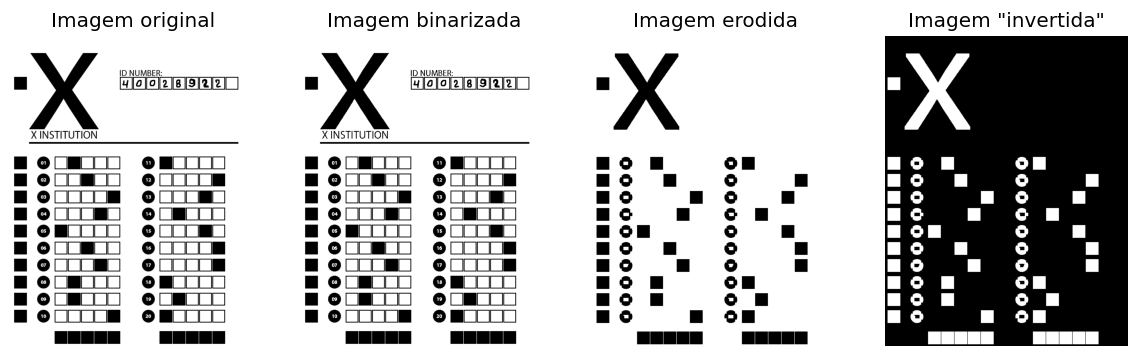

In [21]:
processed_test = mc_test.copy() # manter a imagem original intacta

# "binzarizar" imagem
(thresh, binarified_test) = cv2.threshold(processed_test,
                                         127, 255, cv2.THRESH_BINARY)

# erosion
kernel = np.ones((8,8),np.uint8)
eroded_test = cv2.morphologyEx(binarified_test, cv2.MORPH_CLOSE, kernel)

# inverter imagem
inverted_test = cv2.bitwise_not(eroded_test)

# visualizando cada transformação
p, plots = plt.subplots(1, 4, figsize=(12,12), dpi=120)

plots[0].imshow(processed_test, cmap="gray")
plots[0].title.set_text("Imagem original")

plots[1].imshow(binarified_test, cmap="gray")
plots[1].title.set_text("Imagem binarizada")

plots[2].imshow(eroded_test, cmap="gray")
plots[2].title.set_text("Imagem erodida")

plots[3].imshow(inverted_test, cmap="gray")
plots[3].title.set_text("Imagem \"invertida\"")

### removendo os eixos dos plots
for i in range(4):
    plots[i].axis("off")
    plots[i].axis("off")

## 3. Detecção de margem:
Você deve ter notado que temos alguns quadrados pretos à esquerda e na parte inferior do gabarito, eles são muito úteis para identificar onde está cada resposta; funcionam como "âncoras". Vou explicar como vamos usá-los na próxima parte, por enquanto, vamos apenas detectá-los.

Para fazer isso, podemos somar todas as colunas/linhas da imagem, como uma matriz. Como temos alguns grandes quadrados pretos empilhados, devemos ver alguns picos em cada eixo, por isso invertemos as cores da imagem. Como queremos analisar as áreas em preto, seria muito melhor representar a cor preta por 1, pois podemos somá-las, como no exemplo abaixo.

        0 1 1 1 1 | 4  -> soma das linhas (pico = 4)
        0 1 0 0 0 | 1
        0 1 0 0 0 | 1 
        0 1 0 1 0 | 2 
        ----------+
        0 4 1 2 1   ----> soma das colunas (pico = 4)
 

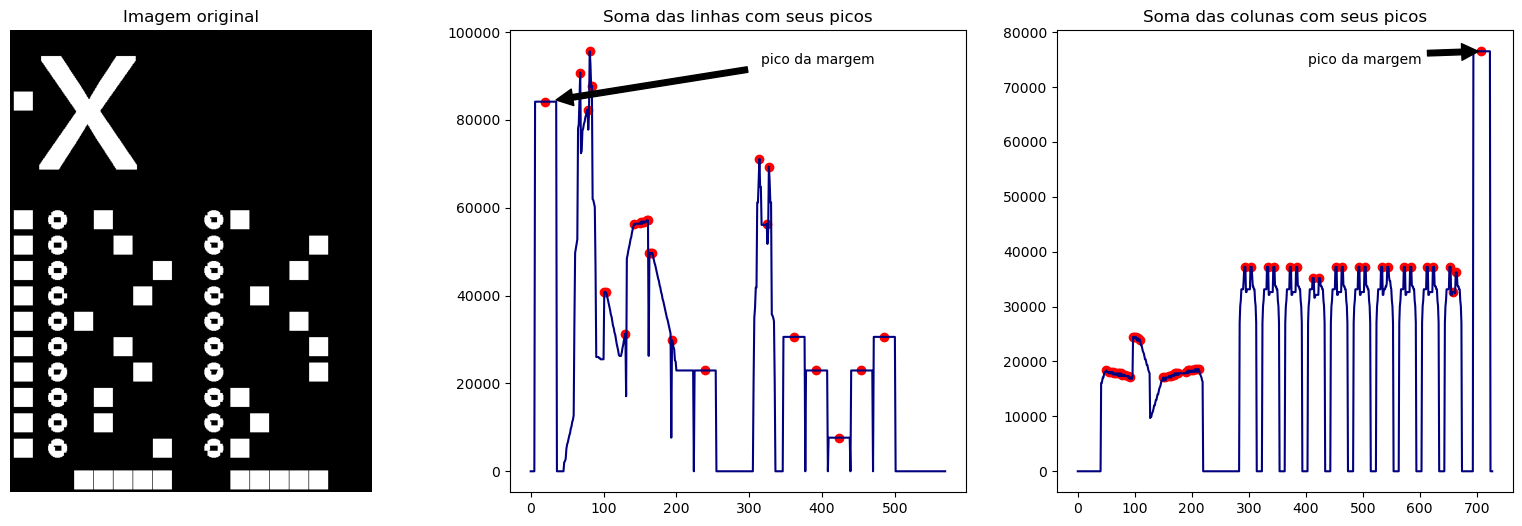

In [22]:
# renomear a variável para melhorar o código
processed_test = inverted_test.copy()

sum_vertical   = processed_test.sum( axis = 0 ) # axis = 0 representa o eixo X
sum_horizontal = processed_test.sum( axis = 1 ) # axis = 1 representa o eixo Y

# obter os picos de cada eixo
vertical_peaks   = find_peaks(sum_vertical)[0]
horizontal_peaks = find_peaks(sum_horizontal)[0]


# gráficos dos picos
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.imshow(processed_test, cmap="gray")
ax1.title.set_text("Imagem original")
ax1.axis("off")

ax2.plot(sum_vertical, c="navy")
ax2.scatter(vertical_peaks, sum_vertical[vertical_peaks], c="r")
ax2.title.set_text("Soma das linhas com seus picos")
ax2.annotate("pico da margem", (vertical_peaks[0], sum_vertical[vertical_peaks][0]),
             xytext=(0.8, 0.95), textcoords="axes fraction",
             arrowprops=dict(facecolor="black", shrink=0.05),
             horizontalalignment="right", verticalalignment="top")

ax3.plot(sum_horizontal, c="navy")
ax3.scatter(horizontal_peaks, sum_horizontal[horizontal_peaks], c="r")
ax3.title.set_text("Soma das colunas com seus picos")
ax3.annotate("pico da margem", (horizontal_peaks[-1], sum_horizontal[horizontal_peaks][-1]),
             xytext=(0.8, 0.95), textcoords="axes fraction",
             arrowprops=dict(facecolor="black", shrink=0.05),
             horizontalalignment="right", verticalalignment="top")

plt.show()

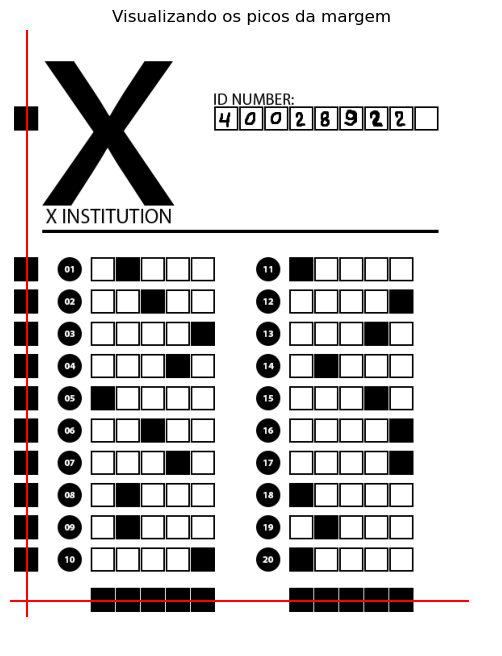

In [23]:
height, width = mc_test.shape

plt.figure(figsize = (20,8))
plt.imshow(mc_test, cmap="gray")
plt.axis("off")
plt.title("Visualizando os picos da margem")

# visualizar cada pico na imagem
plt.vlines(vertical_peaks[0],   0, height, color="red")
plt.hlines(horizontal_peaks[-1], 0, width, color="red")

plt.show()

## 4. Detecção de alternativas:
As linhas vermelhas acima representam onde a margem deve estar. Como podemos ver, encaixou perfeitamente. Agora podemos finalmente tentar ler cada pergunta e ver qual delas está marcada! Para isso, devemos saber exatamente onde cada quadrado está localizado. Se conhecermos a coordenada y de cada margem a partir da esquerda e a coordenada x de cada quadrado a partir de baixo, podemos "cruzá-los" para obter cada quadrado, como ilustrei na imagem abaixo:

![margin example](img/margin-example.png)

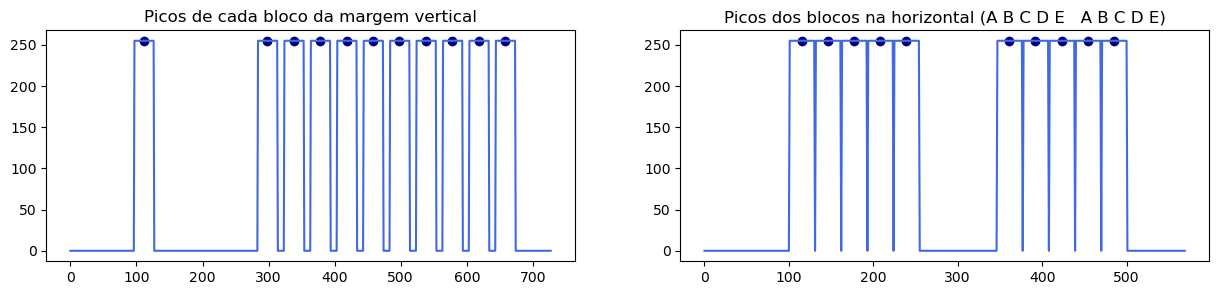

In [24]:
# obter os valores da margem vertical
vertical_margin   = processed_test[:,  vertical_peaks[0]]
# obter os valores da margem horizontal
horizontal_margin = processed_test[horizontal_peaks[-1], :]

# obter os picos em cada eixo
vertical_alternatives_peaks = find_peaks(vertical_margin)[0]
horizontal_alternatives_peaks = find_peaks(horizontal_margin)[0]

# plotando os picos
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,3))

ax1.plot(vertical_margin, color="royalblue")
ax1.scatter(vertical_alternatives_peaks, vertical_margin[vertical_alternatives_peaks], color="navy")
ax1.title.set_text("Picos de cada bloco da margem vertical")

ax2.plot(horizontal_margin, color="royalblue")
ax2.scatter(horizontal_alternatives_peaks, horizontal_margin[horizontal_alternatives_peaks], color="navy")
ax2.title.set_text("Picos dos blocos na horizontal (A B C D E   A B C D E)")


Agora que sabemos as coordenadas exatas de cada caixa, **como sabemos qual caixa está marcada?** Podemos apenas verificar se o pixel na interseção é preto. Se for, então é aquele marcado, mas é muito arriscado, pode ser um pouco de ruído na imagem, o que levaria a um erro. Para evitar isso, poderíamos verificar alguns pixels ao redor. Para isso, usei a variável **"neighborhood"**. A imagem abaixo ilustra brevemente a ideia geral:

![threshold example](img/threshold-example.png)

Agora, ao invés de marcar apenas um pixel, vamos somar todos os pixels da área verde, se forem maiores que um determinado valor, podemos concluir que é aquele que foi marcado!


In [25]:
# vamos checar 9 pixels ao redor (3x3)
neighborhood = 3

# vamos separar cada coluna (de 10 alternativas cada) em listas
first_column  = []
second_column = []

# como o primeiro pico vertical representa o "ID", vamos ignorar por agora
for x in vertical_alternatives_peaks[1:]:
    
    # identificar qual letra cada caixa representa (A,B,C,D,E)
    alternative_counter = 1
    
    for y in horizontal_alternatives_peaks:
        
        # selecionando os pixels na "vizinhança"
        marked_area = processed_test[ x - neighborhood : x + neighborhood :,
                                      y - neighborhood : y + neighborhood ]
        
        # somar todos os valores da matriz
        sum_marked_area = sum(sum(marked_area))
        
        if (sum_marked_area >= (neighborhood) ** 2):
            
            # alternative_counter <= 5 ~> pertence a primeira coluna
            if (alternative_counter <= 5):
                first_column.append(chr(64 + alternative_counter))
                
            # alternative_counter > 5 ~> pertence a segunda coluna
            else:
                second_column.append(chr(59 + alternative_counter))
        
        alternative_counter += 1


answers = first_column + second_column

print("ALTERNATIVAS PREVISTAS:", ", ".join(answers))

ALTERNATIVAS PREVISTAS: B, C, E, D, A, C, D, B, B, E, A, E, D, B, D, E, E, A, B, A


## 5. Detecção dos dígitos escritos a mão:

Como disse na introdução, agora criaremos uma rede neural convolucional (CNN) para reconhecer números escritos a mão. Mas antes de tudo isso, devemos cortar a seção de ID e processa-lá para obtermos melhores resultados.

***

- **"id_margin"** "Margem" para ler a seção toda dos dígitos

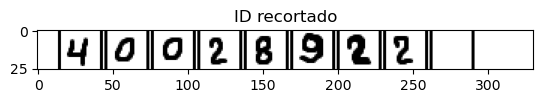

In [26]:
# criando margem e recortando área de interesse
id_margin = 13

id_section = mc_test[ vertical_alternatives_peaks[0] - id_margin :
                      vertical_alternatives_peaks[0] + id_margin, horizontal_alternatives_peaks[4]:]

plt.imshow(id_section, cmap="gray")
plt.title("ID recortado")
plt.show()

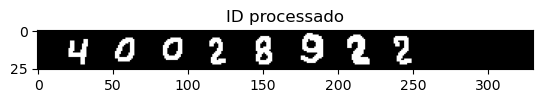

In [27]:
# vamos processar novamente a imagem, igual fizemos anteriormente

(thresh, binarified_id) = cv2.threshold(id_section, 127, 255, cv2.THRESH_BINARY)

kernel = np.ones((3,3),np.uint8)
eroded_id = cv2.morphologyEx(binarified_id, cv2.MORPH_CLOSE, kernel)

inverted_id = cv2.bitwise_not(eroded_id)

plt.imshow(inverted_id, cmap="gray")
plt.title("ID processado")
plt.show()

***
#### Isolando números:

Até agora temos toda a seção de ID, agora só temos que isolar cada número e armazenar todos eles em uma lista para realizar a classificação individual. Para isso, faremos o mesmo que fizemos para detectar a margem, somaremos todas as colunas, devemos ver alguns picos em cada número. Com isso, só precisamos selecionar esses picos.


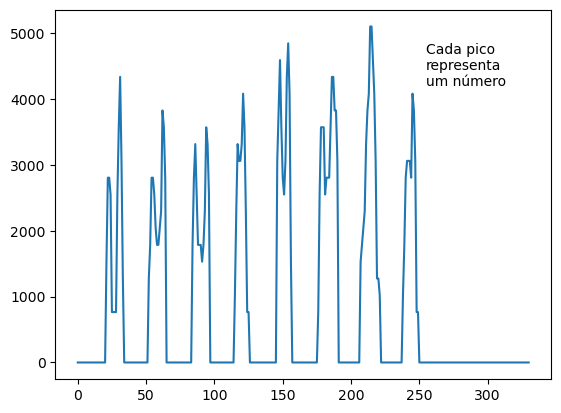

<Figure size 300x100 with 0 Axes>

In [28]:
# melhorar transformações
id_section = inverted_id.copy()

# somar para obter os picos
sum_id_y = id_section.sum(axis=0)

plt.annotate("Cada pico\nrepresenta\num número", (255, 4200))
plt.plot(sum_id_y)
plt.figure(figsize=(3, 1))
plt.show()

Para isolar cada pico, tive uma ideia muito simples. Separei em "pré-pico" e "pós-pico": Nosso numero deve estar entre cada um deles

> Uma coordenada (X) é classificada como um **"pré-pico"** quando f(x) = 0 e f(x+1) > 0.
>
> Uma coordenada (X) é classificada como **"pós-pico"** quando f(x) > 0 e f(x+1) = 0.

Agora é só recortar a imagem do "pré-pico" até o "pós-pico" de cada número e armazená-los em uma lista.

Temos 8 números


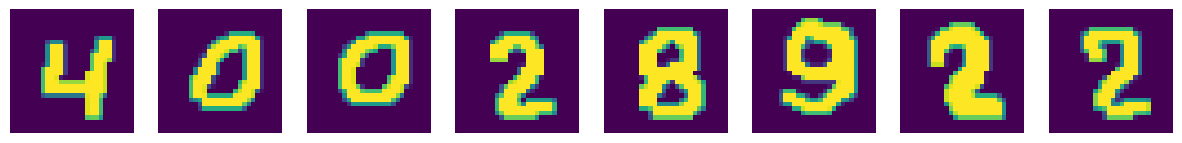

In [29]:
pre_peaks  = []
post_peaks = []
numbers = []

# margem de erro
number_margin = 5

# implementação da ideia acima
for x in range(1, (len(sum_id_y) - 1)):
    
    if (sum_id_y[x] == 0 and sum_id_y[x+1] > 0):
        pre_peaks.append(x)
        
    elif (sum_id_y[x] > 0 and sum_id_y[x+1] == 0):
        post_peaks.append(x)


for peaks in range(len(pre_peaks)):
    
    # isolando cada numero
    number = id_section[: , pre_peaks[peaks] - number_margin : post_peaks[peaks] + number_margin]
    
    # redimensionar para 28x28 pixels, pois é a dimensão das imagens do dataset MNIST
    resized_number = cv2.resize(number, [28,28], interpolation = cv2.INTER_AREA)
    
    # normalizar a imagem (transformar cada pixel num numero entre zero e um)
    resized_img = resized_number / 255
    
    numbers.append(resized_img)
    
len_numbers = len(numbers)
print("Temos %s números" % len_numbers)

fig, ax = plt.subplots(1,len_numbers, figsize=(15,3))

for n in range(len_numbers):
    ax[n].imshow(numbers[n])
    ax[n].axis("off")


MNIST carregado!


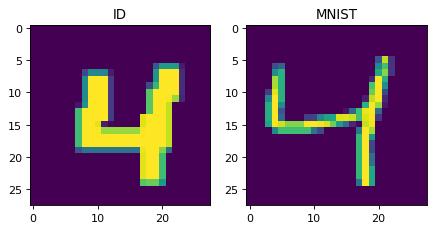

In [30]:
from keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.datasets import mnist

# import mnist dataset -- this might take a bit
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("MNIST carregado!")

# plot MNIST x ID
fig, (ax1, ax2) = plt.subplots(1,2, dpi=80)

ax1.imshow(numbers[0])
ax1.title.set_text("ID")

ax2.imshow(X_train[2])
ax2.title.set_text("MNIST")

## 6. Processando imagens
Como podemos observar acima, as imagens são muito diferentes, vamos processar as imagens do nosso ID para que nossa rede neural tenha êxito em prever quais dígitos foram escritos. Para isso, vamos usar a mesma operação que utilizamos no início, vamos **erodir** nossas imagens.

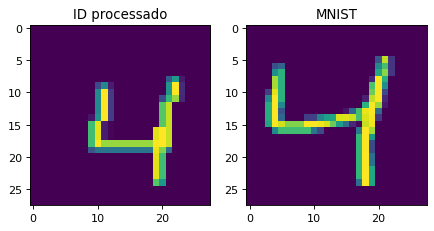

In [31]:
num_prep = numbers.copy()
processed_numbers = []

kernel = np.ones((2, 2), np.uint8)

for img in num_prep:
    img_erosion = cv2.erode(img, kernel, iterations=2)
    processed_numbers.append(img_erosion)

# plot MNIST x ID
fig, (ax1, ax2) = plt.subplots(1,2, dpi=80)

ax1.imshow(processed_numbers[0])
ax1.title.set_text("ID processado")

ax2.imshow(X_train[2])
ax2.title.set_text("MNIST")

Com essa transformações, vemos que nossa imagem do ID agora se parece muito com a imagem do MNIST, então nossa rede neural será capaz de ler nossos dígitos com maior precisão.

***


## 7. Criando nossa rede neural convolucional
Na célula abaixo, usaremos algumas técnicas para pré-processar os dados antes de enviá-los à nossa rede neural.
- **Normalizar dados:** Todas as imagens do conjunto de dados MNIST são valores de 0 a 255; vamos dividir todos os valores por 255. Dessa forma, todos os valores agora estão entre 0 e 1. Redes neurais tendem a funcionar melhor com valores pequenos.


- **One hot encoding:** Como estamos tentando classificar dígitos, temos 10 possibilidades. Com um hot encoding, vamos transformar cada label em um vetor cheio de zeros, onde tem um 1 na posição do label correspondente, ex:

   ***0 → [1, 0, 0, 0, 0, 0, 0, 0, 0]<br>
   1 → [0, 1, 0, 0, 0, 0, 0, 0, 0]<br>
   2 → [0, 0, 1, 0, 0, 0, 0, 0, 0]<br>
   etc...***

In [32]:
# normalizando os dados
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# alterando o tamanho das imagens para utiliza-las na rede neural!
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

# one hot encoding
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)

***
#### Criando o modelo de rede neural:

Agora vamos criar nossa rede neural. Não vou explicar em detalhes o que cada função faz ou como elas funcionam. Vou apenas fazer um rápido resumo.

- **Conv2D:** adiciona uma camada convolucional, que é o bloco de construção de uma rede neural convolucional; basicamente resume as características "memoráveis" de uma determinada parte da imagem.
- **Max Pooling:** Uma camada de pooling "resume" uma camada, temos algumas variações delas. Neste caso, estou usando a "max pooling", você pode verificar quais são as outras camadas de pooling nos artigos abaixo.
- **Flatten:** Vamos "achatar" das camadas para encaixar em nossa rede neural.
- **Dense:** Conecta totalmente uma camada a outra usando N unidades.
- **Dropout:** tem uma pequena chance de ignorar certas partes da rede neural no treinamento. É usado para evitar **overfits**, forçando a IA a aprender diversos padrões em nós diferentes.

> **Overfit** é um termo usado para descrever quando o modelo de IA se ajusta exatamente aos dados de treinamento, perdendo a capacidade de generalizar dados não vistos. É como decorar um livro inteiro, palavra por palavra para uma prova. Você provavelmente falhará porque não será capaz de generalizar perguntas não vistas sobre o assunto.

***

Recomendo ler esses artigos se você quiser aprender mais sobre:
- https://gaussian37.github.io/dl-concept-cnn/
- https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
- https://docs.aws.amazon.com/machine-learning/latest/dg/model-fit-underfitting-vs-overfitting.html

In [14]:
# criando modelo sequencial
model = Sequential()

model.add(Conv2D(32, (3,3), activation="relu", padding="same",
                                            input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64, (3,3), activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 9, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 128)               7

In [15]:
# compilando o modelo
model.compile(loss="categorical_crossentropy", 
                optimizer="adam", metrics=["accuracy"])

# treinando (pode demorar um tempo)
model.fit(X_train, y_train, epochs=10, verbose=2)

Epoch 1/10
1875/1875 - 27s - loss: 0.2923 - accuracy: 0.9093 - 27s/epoch - 15ms/step
Epoch 2/10
1875/1875 - 27s - loss: 0.0907 - accuracy: 0.9751 - 27s/epoch - 14ms/step
Epoch 3/10
1875/1875 - 26s - loss: 0.0675 - accuracy: 0.9815 - 26s/epoch - 14ms/step
Epoch 4/10
1875/1875 - 26s - loss: 0.0546 - accuracy: 0.9849 - 26s/epoch - 14ms/step
Epoch 5/10
1875/1875 - 27s - loss: 0.0457 - accuracy: 0.9869 - 27s/epoch - 14ms/step
Epoch 6/10
1875/1875 - 29s - loss: 0.0373 - accuracy: 0.9891 - 29s/epoch - 15ms/step
Epoch 7/10
1875/1875 - 27s - loss: 0.0361 - accuracy: 0.9895 - 27s/epoch - 14ms/step
Epoch 8/10
1875/1875 - 26s - loss: 0.0316 - accuracy: 0.9911 - 26s/epoch - 14ms/step
Epoch 9/10
1875/1875 - 27s - loss: 0.0285 - accuracy: 0.9921 - 27s/epoch - 14ms/step
Epoch 10/10
1875/1875 - 27s - loss: 0.0242 - accuracy: 0.9930 - 27s/epoch - 14ms/step


In [33]:
loss, accuracy = model.evaluate(X_test, y_test)

print("A IA tem uma precisão de {:.2f}%".format(accuracy*100))

313/313 [==============================] - 2s 6ms/step - loss: 0.0279 - accuracy: 0.9916
A IA tem uma precisão de 99.16%


No pipeline de machine learning, o processo de treinamento geralmente é o mais demorado, dependendo dos seus dados. Felizmente, não precisamos treiná-lo todas as vezes, podemos treiná-lo apenas uma vez e salvar os pesos. Então, da próxima vez que precisarmos prever algum número, podemos simplesmente carregar os pesos e estamos prontos.

No Keras, podemos salvar os pesos usando a função **"save_weights"**.

In [34]:
# model.save_weights("MNIST.h5"')

***
A maneira como o Keras (e outras bibliotecas) gera as previsões pode ser confusa em primeira vista. Suponhamos que temos a imagem de um número; nós o inserimos em nosso modelo. Deverá retornar uma lista com 10 elementos, onde cada elemento corresponde a possibilidade daquela imagem ser o termo, ex:

![prediction example](img/prediction-list.png)

In [35]:
# converter lista de números para um array e mudar seus tamanhos
numbers_array = np.asarray(processed_numbers).reshape(-1,28,28,1)

# prever cada digito
predictions = model.predict(numbers_array)
ID = ""

for p in predictions:
    ID += str(p.argmax())

print("ID:",ID)

1/1 [==============================] - 0s 23ms/step
ID: 40028922


***
### 8. Conclusão:
Tudo pronto, agora vamos fazer uma simulação. Vamos supor que todas as respostas da prova foram a letra A, como esse estudante se sairia?

In [36]:
number_questions = 20
correct_answers = ["A"] * number_questions # "A" N vezes (aqui N=20)
correct = 0

for a in range(len(answers)):
    
    if (answers[a] == correct_answers[a]):
        correct += 1

print("""    ID: {}
    NOTA: {:02d}/{} ({:.1f}/10)""".format(ID, correct, number_questions,
                                       (correct / number_questions) * 10))

    ID: 40028922
    NOTA: 04/20 (2.0/10)



****
Neste cenário fictício, nosso modelo funcionou perfeitamente, mas **deve ser usado na vida real?** Quando se trata da vida real, temos que considerar que nada será perfeito, teremos que lidar com ruído e erros humanos, que este algoritmo **NÃO** está pronto para enfrentar. Por exemplo, se alguém preenchesse duas caixas em uma pergunta, nosso algoritmo consideraria ambas em vez de simplesmente cancelá-la. Temos muitos outros problemas a serem resolvidos, em futuras atualizações corrigirei cada uma delas.